<a href="https://colab.research.google.com/github/didi64/Colab_Test/blob/main/Classifiy_Reviews1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os, sys
from google.colab import drive
ROOT = '/content/drive/MyDrive/CAS_Gregi/'
IMPORT_PATH_SYMLINK = {'link': '/content/modules', 'target': ROOT + 'CO_modules'}

drive.mount('/content/drive', force_remount=False)
if not os.path.exists(IMPORT_PATH_SYMLINK['link']):
    os.symlink(IMPORT_PATH_SYMLINK['target'], IMPORT_PATH_SYMLINK['link'])
if IMPORT_PATH_SYMLINK['link'] not in sys.path:
    sys.path.insert(0, IMPORT_PATH_SYMLINK['link'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%env NLTK_DATA={IMPORT_PATH_SYMLINK['link']}
!pip install --target={IMPORT_PATH_SYMLINK['link']} contractions
!python -m textblob.download_corpora
!pip install --target={IMPORT_PATH_SYMLINK['link']} autocorrect

In [7]:
import pickle
import random

def get_train_test(seed = 42):
    '''returns two dicts train, test
       both dicts have keys [1,2,3,4,5]
       train[i] is a list of reviews with score i
    '''
    random.seed(seed)
    #root = '/content/drive/My Drive/CAS_Gregi/'


    with open(ROOT + 'data/reviews_with_GPT_scores_dict.pkl','rb') as f:
        review_dict = pickle.load(f)

    with open(ROOT + 'data/bad_reviews_2000_tuples.pkl','rb') as f:
        bad_reviews = pickle.load(f)

    for review, score in bad_reviews:
        review_dict[int(score)].append(review)

    idx = list(range(1200))
    random.shuffle(idx)


    train_reviews = {k: [v[i] for i in idx[:1000]] for k,v in review_dict.items()}
    test_reviews  = {k: [v[i] for i in idx[1000:]] for k,v in review_dict.items()}

    return train_reviews, test_reviews

In [8]:
data_train, data_test = get_train_test()

In [9]:
data_test[1][0]

'The staff was incredibly rude and unhelpful. They seemed annoyed by any questions or requests, and made me feel like I was inconveniencing them.\n'

In [6]:
import contractions
for x,y in contractions.contractions_dict.items():
    x =x.replace("'", ' ')
    contractions.add(x, y)

In [7]:
from autocorrect import Speller
spell = Speller(lang='en')

In [8]:
from textblob import TextBlob
import re
import string

In [9]:
PUNCT = re.compile(r'[{}\d_\n]'.format(re.escape(string.punctuation)))

def tag_and_normalize(text, cond = lambda x: True, stopwords = ()):
    '''returns normalized text
      - removes contractions,
      - removes punctuation and numbers and _
      - spellchecks the word
      - lemmatazies the word depending on its part of speech
        for all words with a tag so that cond(tag) is True

      cond: function f(tag) -> bool
    '''
    # tagged words
    words = []
    tt = {'J': 'a', 'R': 'a', 'V':'v', 'N': 'n'}

    text = contractions.fix(text)
    text = PUNCT.sub(' ', text)
    tb = TextBlob(text).lower().correct()

    for word, tag in tb.tags:
        if word in  stopwords:
            continue


        # only keek adj, adv, and past participes like broken,
        # advertized, cleaned,... or gerund, i.e. smelling, working, bothering,...
        if cond(tag):
            word = word.lemmatize(tt.get(tag[0]))
            words.append((word, tag))


    return words


def normalize(text):
    text = contractions.fix(text)
    text = PUNCT.sub(' ', text)
    # tb = TextBlob(text).lower().correct()
    # tb.raw
    #text = spell(text)
    #return TextBlob(text).lower().correct().raw
    return spell(text)

def clean_reviews(review_dict):
    data_ = {k:[normalize(x) for x in v] for k,v in review_dict.items()}
    data  = {k:[x.lower().strip() for x in v] for k,v in data_t.items()}
    return data

In [16]:
res = []
cond = lambda tag: tag[0] in 'JR' or  tag in ('VBN', 'VBG')
for review in data_test[1][:10]:
    res.append(tag_and_normalize(review, cond = cond))

# res

In [63]:
normalize('got? no wi fi or wifi')

'got  no wi fi or wifi'

In [18]:
res[3][1]

('desirable', 'JJ')

In [ ]:
data_train_clean, data_test_clean = [clean_reviews(r) for r in (data_train, data_test)]

In [73]:
train_test = (data_train_clean, data_test_clean)

In [74]:
#  with open(ROOT + 'data/hotelreviews_cleaned_train_test_spell.pkl','wb') as f:
#     pickle.dump(train_test,f)

In [75]:
with open(ROOT + 'data/hotelreviews_cleaned_train_test_spell.pkl','rb') as f:
    train_test = pickle.load(f)

In [76]:
from functools import reduce
all_reviews = reduce(lambda x,y: x + y, [[(r, k) for d in train_test for k,v in d.items() for r in v]])

In [77]:
all_reviews[4100:4102]

[('the wi fi was practically non existent  trying to connect to the internet was a constant struggle  which was incredibly frustrating in today s connected world',
  1),
 ('the entire hotel spelled like mold  and our room was no exception  the shower had poor water pressure  and the temperature kept fluctuating between scaling hot and freezing cold  the staff seemed indifferent to our complaints  definitely not what we expected',
  1)]

In [59]:
TextBlob(' got not wi fi').correct()

TextBlob(" got not i i")

Text(0, 0.5, 'Reviews')

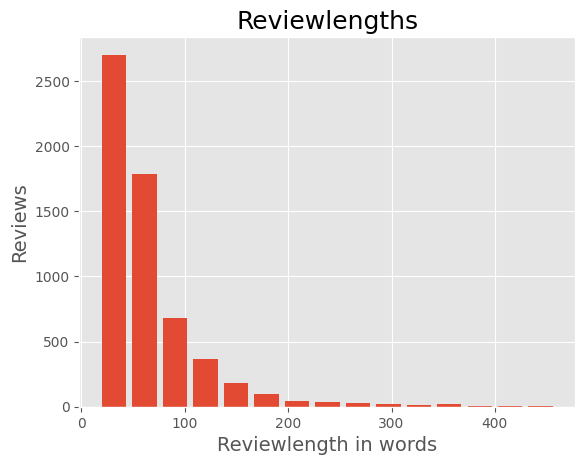

In [79]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

counts = sorted([len(review[0].split()) for review in all_reviews])
plt.hist(counts, bins = 15, rwidth = 0.8)
plt.title('Reviewlengths', fontsize=18)
plt.xlabel('Reviewlength in words', fontsize=14)
plt.ylabel('Reviews', fontsize=14)

